# Train segmentation model

## Import libs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import os
import random
import numpy as np
from matplotlib import pyplot as plt

# Reproducibility
random.seed(0)
os.environ['PYTHONHASHSEED'] = str(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


## Load data

In [3]:
from dataset import ISIC2018_dataloader

train_dataset = ISIC2018_dataloader("datasets/ISIC2018")
test_dataset = ISIC2018_dataloader("datasets/ISIC2018", is_train=False)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8) # 32 for others
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

In [4]:
# dt = next(iter(train_dataloader))
# x = dt["image"]
# y = dt["mask"]
# x.shape, y.shape

In [5]:
# def to_img(ten):
#     ten =(ten[0].permute(1,2,0).detach().cpu().numpy()+1)/2
#     ten=(ten*255).astype(np.uint8)
#     return ten

# a = to_img(x)
# print(a.shape)
# plt.imshow(a)
# #plt.imshow(a, cmap='gray')

## Load model

In [6]:
from model import * 

# Define model
model = build_resnet50_unet()

# Send to GPU and initialize weights
model = model.to(DEVICE)
model.apply(weights_init)

build_resnet50_unet(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (input_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (down_blocks): ModuleList(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
    

In [7]:
# All parameters
all_params = sum(p.numel() for p in model.parameters())
print("All parameters ", all_params)

# Trainable parameters
all_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters ", all_train_params)

# Unet 32440001
# Resunet mini 
# Resunet 10980064
# Resnet50 encoder Unet 147808641

All parameters  147808641
Trainable parameters  147808641


## Setup optim and loss

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss() # loss combines a Sigmoid layer and the BCELoss in one single class

## Train and eval functions

In [10]:
def train(model, epoch):
    model.train()
    for batch_idx, data in enumerate(train_dataloader):
        data, target = data["image"].to(DEVICE), data["mask"].to(DEVICE)
        output = model.forward(data.float())
        loss = criterion(output.float(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # if batch_idx % 10 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_dataloader.dataset),
        #         100. * batch_idx / len(train_dataloader), loss.data))
            
def test(model):
    model.eval()
    
    with torch.no_grad():
        test_loss = 0
        jaccard = 0
        dice = 0

        for data in test_dataloader:
            data, target = data["image"].to(DEVICE), data["mask"].to(DEVICE)
            output = model(data.float())  
            test_loss += criterion(output.float(), target.float()).item()
            
            output = torch.sigmoid(output) # Turn activations into probabilities by feeding through sigmoid
            gt = target.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy()
            pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5

            intersection = pred * gt
            union = pred + gt - intersection
            jaccard += (np.sum(intersection)/np.sum(union))  
            dice += (2. * np.sum(intersection) ) / (np.sum(pred) + np.sum(gt))
    
        test_loss /= len(test_dataloader)
        jaccard /= len(test_dataloader)
        dice /= len(test_dataloader)

        losses.append(test_loss)
        jacs.append(jaccard)
        dices.append(dice)


        print('Average Loss: {:.3f}'.format(test_loss))
        print('Jaccard Index : {:.3f}'.format(jaccard * 100))
        print('Dice Coefficient : {:.3f}'.format(dice * 100))
        print('==========================================')
        print('==========================================')

## Train model

In [11]:
losses = []
jacs = []
dices = []

for epoch in range(1, 200):
    train(model, epoch)
    print("Epoch: {}".format(epoch))
    test(model)

NameError: name 'UNetWithResnet50Encoder' is not defined

In [ ]:
max(jacs), max(dices)

In [12]:
# unet
# (0.8009421322064075, 0.8792538881655937)

# resunet
# (0.8128665314129552, 0.8853718218059683)

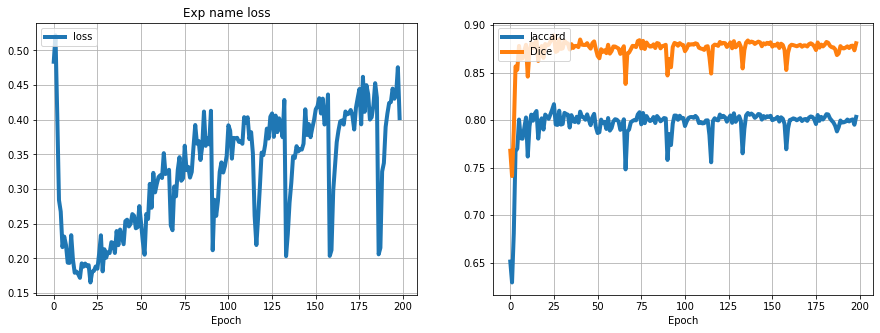

In [13]:
# Plot training & validation loss values
# b, g, r, y, o, -g, -m,

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(losses,linewidth=4)
plt.title('{} loss'.format("Exp name"))
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'], loc='upper left')
plt.grid(True)

# Plot training & validation iou_score values

plt.subplot(122)
plt.plot(jacs,linewidth=4)
plt.plot(dices,linewidth=4)
#plt.title('{} IOU score'.format(experiment_name))
#plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Jaccard', 'Dice'], loc='upper left')
# plt.savefig('{}/{}_graph.png'.format(log_path, experiment_name), dpi=300)
plt.show()

## Save model

In [14]:
torch.save(model.state_dict(), 'logs/resunet.pth')